<a href="https://colab.research.google.com/github/ZosoV/aco_random_walk/blob/main/notebooks/aco_tsp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
# Python Implementation of ACO for Travelling Salesman Problem
This is a python implementation of the Ant Colony Optimization algorithm for the Travelling Salesman Problem

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Proyectos/aco_random_walk/

/content/gdrive/MyDrive/Proyectos/ACO


In [ ]:
# import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import enum
import numpy as np
import random
import os
import pandas as pd
from collections import Counter

For each problem, we have to define a weighted undirected graph $G(N,E)$

# Travelling Salesman (TSP) Problem

In this part, we create the graph according to well-known datasets from
1. [TSP Lib](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/)
2. [TSP Updated Dataset](https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html)

The datasets have the extension .tsp and could be found in the attached information.


In [ ]:
# loading the information in a graph with the library networkx
class TSPGraph(nx.Graph):
  def __init__(self, tau_0, dimension, filename = None):
    """Define a graph environment given a filename, 
    and tau_0 (initial pheromone)
    """
    self.tau_0 = tau_0
    self.n_nodes = dimension
    self.dataset = filename
    nx.Graph.__init__(self) 
    self.__adding_nodes(self.dataset)
    self.__adding_edges(self.tau_0)
  
  def __adding_nodes(self,filename):

    with open(os.path.join(DATA_DIR,filename), "r") as f:
      get_nodes = False

      counter_nodes = 0
      for line in f:
        line = line.strip()

        # get the best solution value
        if "BEST_SOLUTION" in line:
          str_best = line.split(":")[-1].strip()
          self.best_solution = float(str_best)
          print(self.best_solution, type(self.best_solution))

        if get_nodes and counter_nodes < self.n_nodes:
          idx, posx, posy = line.split(" ")

          self.add_node(counter_nodes, pos=(float(posx),float(posy))) 

          counter_nodes += 1

        if "NODE_COORD_SECTION" in line: 
          get_nodes = True

  def __adding_edges(self, tau_0):
    for i in range(self.n_nodes):
      for j in range(self.n_nodes):
        if i < j:
          x1, y1 = self.nodes[i]['pos']
          x2, y2 = self.nodes[j]['pos']

          distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)

          self.add_edge(i, j, 
                pheromone = tau_0, 
                distance = distance)

  #Function to plot the structure of the graph
  def draw_graph(self, node_color='blue', node_size=25, with_labels=False, draw_edges = False):
    """
    Draw the graph.
        
    node_size: the size of all the nodes
    node_color: the color of all the nodes
    with_labels: True or False to show the ids of the nodes
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal') #set the x and y axes to the same scale
    pos = nx.get_node_attributes(self, 'pos')
    if draw_edges:
      nx.draw(self, pos, node_color=node_color, node_size=node_size, with_labels=with_labels)
    else:
      nx.draw(self, pos, node_color=node_color, node_size=node_size, with_labels=with_labels, edgelist = [])

  


33523.0 <class 'float'>


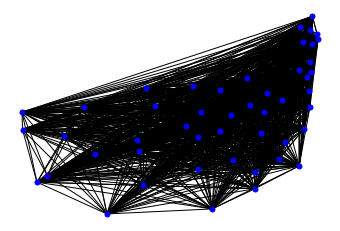

In [ ]:
tsp_graph = TSPGraph(0.1, 48, "att48.tsp")
tsp_graph.draw_graph(draw_edges = True)

In [ ]:
tsp_graph.edges[(0,1)]['pheromone'] = 0.2
tsp_graph.edges[(1,0)]['pheromone']

0.2

33523.0 <class 'float'>


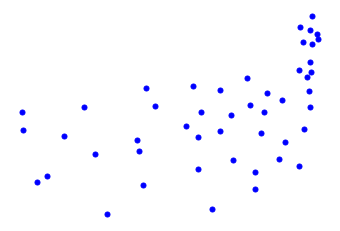

In [ ]:
tsp_graph = TSPGraph(0.1, 48, "att48.tsp")
tsp_graph.draw_graph(draw_edges = False)

### ACO for Travelling Salesman Problem

In [ ]:
class ACOTSP(AntColonyOptimizer):
  def __init__(self, graph, ants, alpha, beta, p, local_p = None, intensity = None, q_0 = None):
    """
    Ant colony optimizer for Path Planning.  
    Traverses a graph and finds the min weight distance 
    between a start and target node
    
    :param graph: graph environment
    :param ants:  number of ants to traverse the graph
    :param alpha: weighting of pheromone
    :param beta:  weighting of heuristic
    :param p:     evaporation rate at which pheromone evaporates
    :param local_p: local evaporation rate at which pheromone evaporates (optional)
    :param intensity: the amount of pheromones to add per edge (optional)
    :param q_0: probability to choose the best construction step (optional)
    """
    self.start_node = 0
    super().__init__(graph, ants, alpha, beta, p, local_p, intensity, q_0)

  def update_state(self):
    neighbors = self.graph[self.current_position]

    # Process to get the weight of each neighbor
    weights = []
    aux_weights = []
    neighbors_idx = []
    for neighbor_node, edge in neighbors.items():

      heuristic = 1 / edge['distance']

      if not self.is_visited(neighbor_node):
        # get the weight per neighbor and append it
        weights.append( (edge['pheromone'] ** self.alpha) * 
                      ( heuristic ** self.beta))
        aux_weights.append( edge['pheromone'] * 
                      (heuristic ** self.beta))
        neighbors_idx.append(neighbor_node)

    if len(weights) != 0:
      acu_weight = sum(weights)
      probabilities = np.array(weights)/acu_weight
      #print("[INFO] probabilities: {}".format(probabilities))

      # with probability q_0 select the best trial
      if self.q_0 is not None:
        if np.random.rand() < self.q_0:
          new_position = neighbors_idx[np.argmax(aux_weights)]
        else:
          # choose an option following the wheel selection algorithm  
          new_position = random.choices(neighbors_idx, weights = probabilities)[0]
      else:
        # choose an option following the wheel selection algorithm  
        new_position = random.choices(neighbors_idx, weights = probabilities)[0]

      # perform local evaporation
      if self.local_p is not None:
        self.local_evaporation(new_position)

      self.current_path.append((self.current_position, new_position))
      self.visited_nodes.append(new_position)
      self.current_position = new_position
    else:      
      self.current_path.append((self.current_position, self.start_node))
      self.visited_nodes.append(self.start_node)
      self.current_position =  self.start_node

  def end_route(self):
    return self.current_position == self.start_node

In [ ]:
# Define the parameters of our model
ants = 10
tau_0 = 1
alpha = 2. 
beta = 1.
p = 0.3
intensity = None

total_iter = 500
step_plot = 10

local_p = 0.4
q_0 = 0.3

33523.0 <class 'float'>


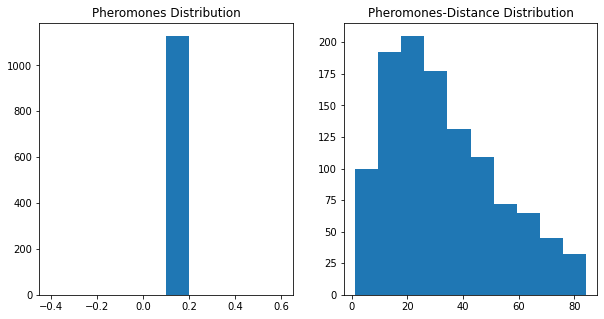

In [ ]:
# Create the graph
graph = TSPGraph(0.1, 48, "att48.tsp")

# Create the envioronment
optimizer = ACOTSP(graph, ants, alpha, beta, p, local_p, intensity, q_0)
#draw_grid(env)
display_pheromones(optimizer,10)

In [ ]:
list_distances = []
list_distances_avg = []

for iter in range(total_iter):

  distance_per_ants = []

  for ant in range(optimizer.ants):
    
    get_target = False
    while not get_target:
      optimizer.update_state()
      get_target = optimizer.end_route()
      
    optimizer.update_best_path()
    current_distance = optimizer.get_total_distance(optimizer.current_path)
    #print("[INFO] iter: {} ant: {} current: {}".format(iter, ant, current_distance))
    distance_per_ants.append(current_distance)
    optimizer.start_node = np.random.randint(0,48)
    optimizer.reset_environment()

  #optimizer.draw_grid()
  optimizer.offline_pheromone_update()

  # Track the best distance so far
  best_distance = optimizer.get_total_distance(optimizer.best_path)
  if iter % step_plot == 0:
    print("[INFO] iter: {} best: {} d_mean: {} d_stdv: {}".format(iter, 
                                                          best_distance, 
                                                          np.mean(distance_per_ants),
                                                          np.std(distance_per_ants)))
    #display_pheromones(env,10)
  list_distances.append(best_distance)
  list_distances_avg.append(np.mean(distance_per_ants))

[INFO] iter: 0 best: 72946.8709588917 d_mean: 88956.67004376012 d_stdv: 10966.828835766877
[INFO] iter: 10 best: 44768.824581247194 d_mean: 56679.71624998244 d_stdv: 6583.888108539997
[INFO] iter: 20 best: 41981.484837360505 d_mean: 53587.145472516655 d_stdv: 5951.260545374647
[INFO] iter: 30 best: 38476.87864480143 d_mean: 54413.54196180873 d_stdv: 7567.71074718774
[INFO] iter: 40 best: 38476.87864480143 d_mean: 56275.79551874193 d_stdv: 4929.408677903402
[INFO] iter: 50 best: 38476.87864480143 d_mean: 57950.888802805006 d_stdv: 5363.800274644261
[INFO] iter: 60 best: 38476.87864480143 d_mean: 56331.77684652495 d_stdv: 8436.233363641111
[INFO] iter: 70 best: 38476.87864480143 d_mean: 56922.30567429676 d_stdv: 6194.860357531522
[INFO] iter: 80 best: 38476.87864480143 d_mean: 52730.955792260844 d_stdv: 4818.932140872716
[INFO] iter: 90 best: 38476.87864480143 d_mean: 58963.326630168056 d_stdv: 6252.38631505985
[INFO] iter: 100 best: 38476.87864480143 d_mean: 54101.610792354986 d_stdv: 3

In [ ]:
#@title Function to plot the best distance per iteration
# plot the best distance per iteration
def plot_distance(list_distances, save = False, name2save = ""):

  list_iterations = np.arange(0, len(list_distances))
  #path_to_save = "stuff/figures/"
  #if not os.path.exists(path_to_save):
  #    os.mkdir(path_to_save)

  title = 'Average Distance vs Iterations'
  title += '\n ants: {} tau_0: {} alpha: {} beta: {} p: {}'.format(
      ants,
      tau_0,
      alpha,
      beta, 
      p
  )

  plt.title(title)
  plt.plot(list_iterations, list_distances, "b-") #, label = label)
  plt.legend()
  #if save: plt.savefig(os.path.join(path_to_save,name2save))

  plt.show()
  plt.close()

No handles with labels found to put in legend.


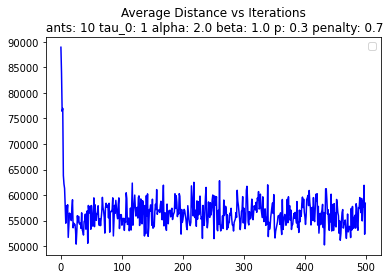

In [ ]:
plot_distance(list_distances_avg)